<a href="https://colab.research.google.com/github/Tahahaha7/Quantitative_Trading/blob/main/%5BIL181%5D_Quantitative_Trading_Zipline_RSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\text{Zipline Tutorial}$$
### $$\text{Relative Strength Index (RSI)}$$

## $\text{Setting Environment}$

In [2]:
%%capture
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz

In [3]:
import os
os.chdir('ta-lib')

In [4]:
%%capture
!./configure --prefix=/usr
!make
!make install

In [5]:
os.chdir('../')

In [6]:
%%capture
!pip install zipline
!pip install pyfolio
!pip install TA-Lib
!pip install yahoofinancials

In [7]:
#!apt-get install libatlas-base-dev python-dev gfortran pkg-config libfreetype6-dev hdf5-tools

## $\text{Running RSI without transaction costs}$

In [1]:
%load_ext zipline

In [2]:
!zipline ingest -b quantopian-quandl

[2021-02-09 19:36:59.281024] INFO: zipline.data.bundles.core: Ingesting quantopian-quandl.
[2021-02-09 19:37:10.595927] INFO: zipline.data.bundles.quandl: Writing data to /root/.zipline/data/quantopian-quandl/2021-02-09T19;36;58.906212.


In [ ]:
%%zipline --start 2015-1-1 --end 2018-1-1 --capital-base 10000.0 -o rsi.pkl 

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent, set_benchmark, order_target_percent, set_slippage
from zipline.finance import commission
import talib as ta


def initialize(context):

  # Stocks to trade
  stock_list = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
  context.stocks = [symbol(stock) for stock in stock_list]

  # How much of the portfolio is invested in each stock (20% each)
  context.target_pct_per_stock = 1 / len(context.stocks)

  # Transaction costs
  #context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
  #context.set_commission(commission.PerDollar(cost=0.0015)) # default is 0.0015
  #context.set_commission(commission.PerTrade(cost=0.0))

  # Slippage
  #context.set_slippage(slippage.VolumeShareSlippage())

  # Upper and Lower bound for RSI trading signals
  context.low_rsi = 30
  context.high_rsi = 70

  # Moving average window
  #context.index_average_window = 100

  set_benchmark(False)

def handle_data(context, data):

  # Historical data
  prices = data.history(context.stocks, 'price', bar_count=20, frequency='1d')
  
  rsis = {}

  # Loop thru the stocks and determine when to buy and sell them
  for stock in context.stocks:
    rsi = ta.RSI(prices[stock], timeperiod=14)[-1]
    rsis[stock] = rsi
  
    current_position = context.portfolio.positions[stock].amount

    if rsi > context.high_rsi and current_position > 0 and data.can_trade(stock):
      order_target(stock, 0)
    elif rsi < context.low_rsi and current_position == 0 and data.can_trade(stock):
      order_target_percent(stock, context.target_pct_per_stock)

  
  record(fb_rsi=rsis[symbol('FB')],
         amzn_rsi=rsis[symbol('AMZN')],
         aapl_rsi=rsis[symbol('AAPL')],
         nflx_rsi=rsis[symbol('NFLX')],
         googl_rsi=rsis[symbol('GOOGL')])

Start date,2015-01-02
End date,2017-12-29
Total months,35
,Backtest
Annual return,12.9%
Cumulative returns,43.7%
Annual volatility,9.0%
Sharpe ratio,1.40
Calmar ratio,1.35
Stability,0.94
Max drawdown,-9.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.54,2016-01-06,2016-02-08,2016-05-23,99
1,4.46,2015-07-20,2015-08-24,2015-08-27,29
2,4.16,2016-11-08,2016-11-14,2016-11-21,10
3,3.18,2016-05-31,2016-06-27,2016-06-30,23
4,3.12,2016-11-22,2016-12-01,2016-12-07,12


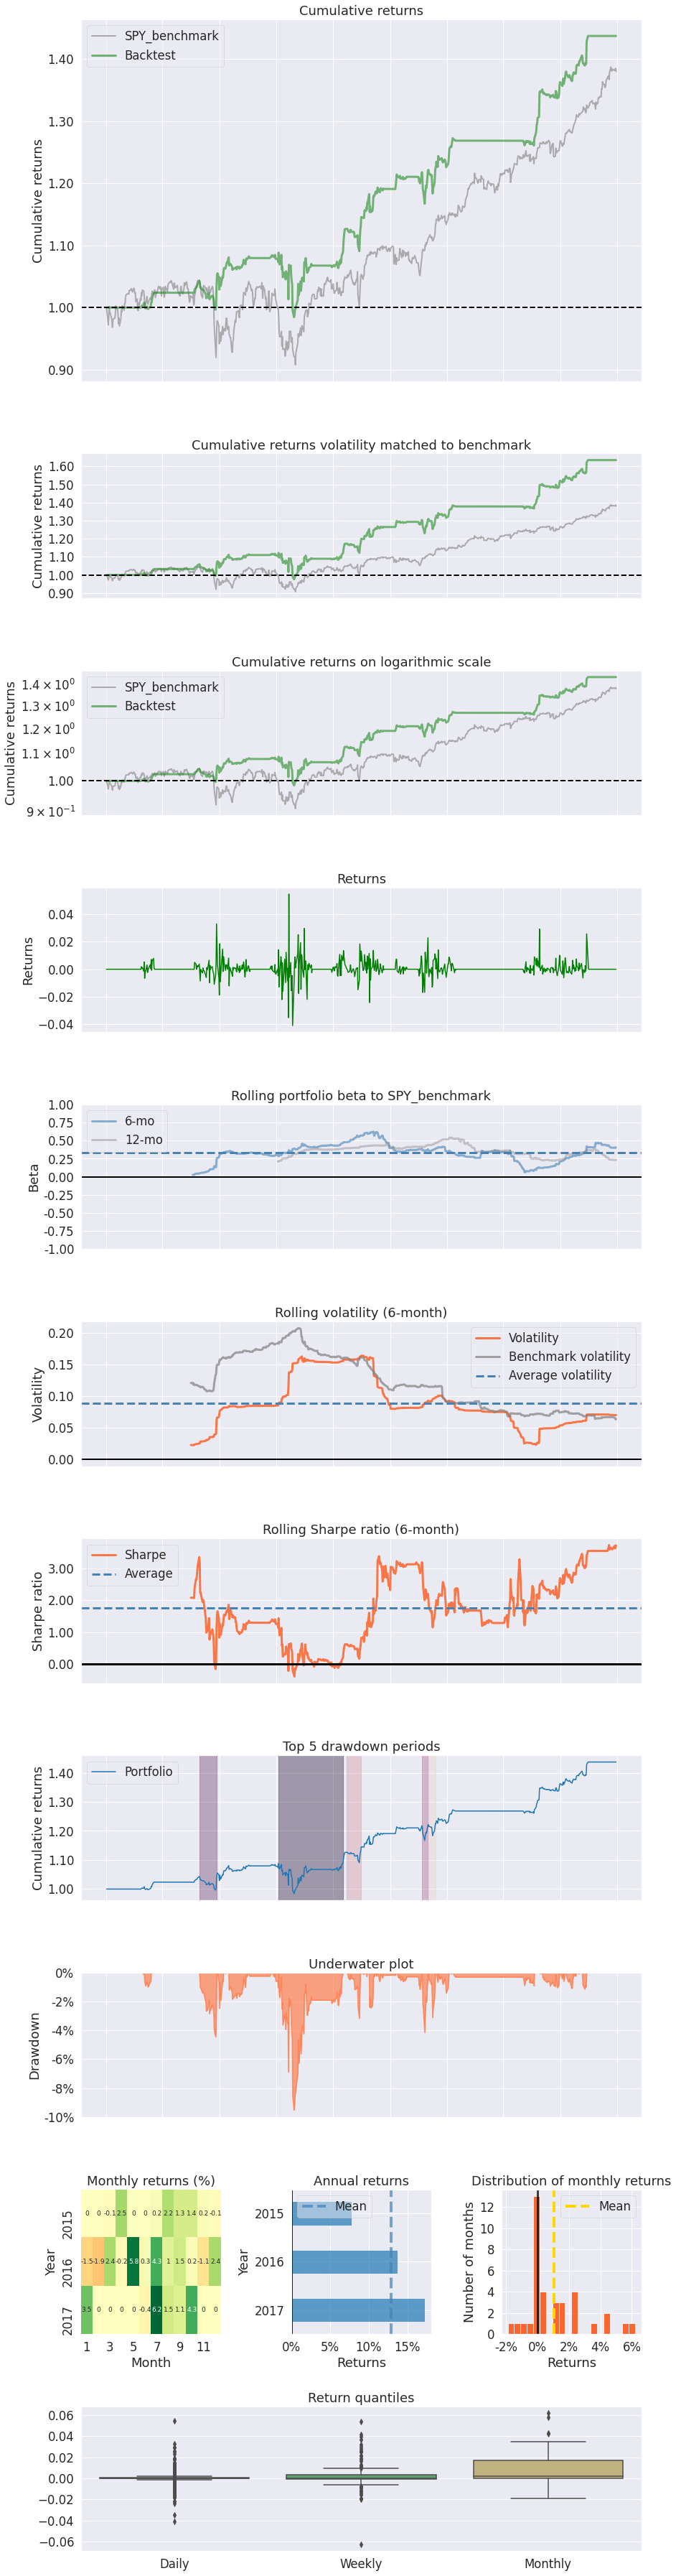

In [4]:
# Plotting tear sheet (simple/extended)
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

#rsi = pd.read_pickle("rsi.pkl")
#pf.create_simple_tear_sheet(rsi.returns);
#pf.create_returns_tear_sheet(rsi.returns);
#pf.create_full_tear_sheet(rsi.returns);

def process_performance(fname):
    perf = pd.read_pickle('{}.pkl'.format(fname))
    perf.to_csv('{}.csv'.format(fname))
    # Normalize the dates
    perf.index = perf.index.normalize()
    return perf

def create_benchmark(fname):
    # benchmark_rets (pd.Series, optional) -- Daily noncumulative returns of the benchmark. This is in the same style as returns.
    dir = 'https://raw.githubusercontent.com/quantopian/zipline/master/zipline/resources/market_data/'
    bench = pd.read_csv(dir+'{}.csv'.format(fname), index_col='date', parse_dates=True, date_parser=lambda col: pd.to_datetime(col, utc=True))
    # Create a series
    bench_series = pd.Series(bench['return'].values, index=bench.index)
    bench_series.rename(fname, inplace=True)
    return bench_series

# Use PyFolio to generate a performance report - benchmark_rets is optional
def analyze(perfdata, benchdata):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perfdata)
    # pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchdata)
    pf.create_returns_tear_sheet(returns, benchmark_rets=benchdata)


# Create the performance dataframe
perf = process_performance('rsi')

# Create a benchmark dataframe
bench_series = create_benchmark('SPY_benchmark')

# Filter for the dates in returns to line up the graphs - normalize cleans up the dates
bench_series = bench_series[bench_series.index.isin(perf.index)]

# Run the tear sheet analysis
analyze(perf, bench_series)

## $\text{Running RSI with transaction costs}$

In [ ]:
%%zipline --start 2015-1-1 --end 2018-1-1 --capital-base 10000.0 -o rsi_costs.pkl

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent, set_benchmark, order_target_percent, set_slippage
from zipline.finance import commission, slippage
import talib as ta


def initialize(context):

  # Stocks to trade
  stock_list = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
  context.stocks = [symbol(stock) for stock in stock_list]

  # How much of the portfolio is invested in each stock (20% each)
  context.target_pct_per_stock = 1 / len(context.stocks)

  # Transaction costs
  
  #context.set_commission(us_equities=commission.PerShare(cost=0.005, min_trade_cost=1))
  context.set_commission(commission.PerDollar(cost=0.0015)) # default is 0.0015
  #context.set_commission(commission.PerTrade(cost=0.0))

  
  # Slippage
  context.set_slippage(slippage.VolumeShareSlippage())


  # Upper and Lower bound for RSI trading signals
  context.low_rsi = 30
  context.high_rsi = 70

  # Moving average window
  #context.index_average_window = 100

  set_benchmark(False)

def handle_data(context, data):

  # Historical data
  prices = data.history(context.stocks, 'price', bar_count=20, frequency='1d')
  
  rsis = {}

  # Loop thru the stocks and determine when to buy and sell them
  for stock in context.stocks:
    rsi = ta.RSI(prices[stock], timeperiod=14)[-1]
    rsis[stock] = rsi
  
    current_position = context.portfolio.positions[stock].amount

    if rsi > context.high_rsi and current_position > 0 and data.can_trade(stock):
      order_target(stock, 0)
    elif rsi < context.low_rsi and current_position == 0 and data.can_trade(stock):
      order_target_percent(stock, context.target_pct_per_stock)

  
  record(fb_rsi=rsis[symbol('FB')],
         amzn_rsi=rsis[symbol('AMZN')],
         aapl_rsi=rsis[symbol('AAPL')],
         nflx_rsi=rsis[symbol('NFLX')],
         googl_rsi=rsis[symbol('GOOGL')])

Start date,2015-01-02
End date,2017-12-29
Total months,35
,Backtest
Annual return,12.4%
Cumulative returns,42.0%
Annual volatility,9.0%
Sharpe ratio,1.35
Calmar ratio,1.30
Stability,0.94
Max drawdown,-9.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.59,2016-01-06,2016-02-08,2016-05-24,100
1,4.50,2015-07-20,2015-08-24,2015-08-27,29
2,4.07,2016-11-08,2016-11-14,2016-11-21,10
3,3.25,2016-05-31,2016-06-27,2016-06-30,23
4,3.07,2016-11-22,2016-12-01,2016-12-07,12


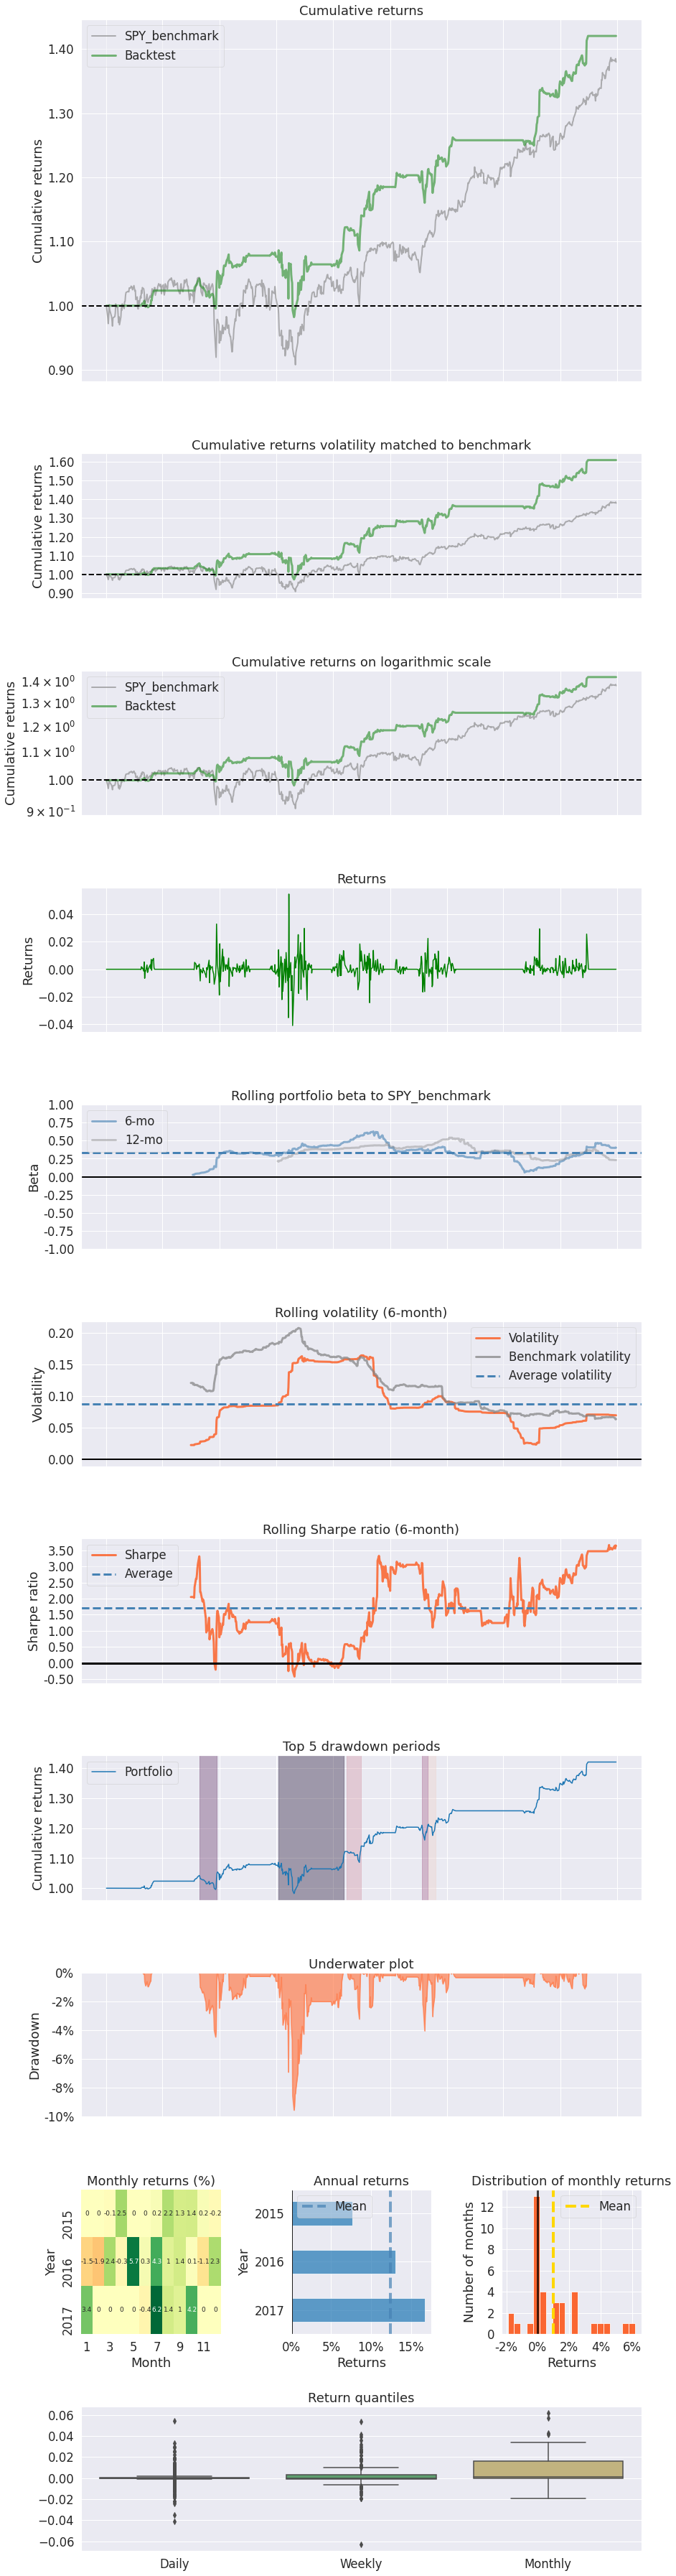

In [6]:
# Plotting tear sheet (simple/extended)

#rsi_costs = pd.read_pickle("rsi_costs.pkl")
#pf.create_simple_tear_sheet(rsi_costs.returns);
#pf.create_returns_tear_sheet(rsi_costs.returns);

# Create the performance dataframe
perf = process_performance('rsi_costs')

# Create a benchmark dataframe
bench_series = create_benchmark('SPY_benchmark')

# Filter for the dates in returns to line up the graphs - normalize cleans up the dates
bench_series = bench_series[bench_series.index.isin(perf.index)]

# Run the tear sheet analysis
analyze(perf, bench_series)

In [7]:
#pf.create_bayesian_tear_sheet(pd.read_pickle("rsi_costs.pkl").returns, live_start_date='2016-01-01');
#help(pf.create_bayesian_tear_sheet)

## $\text{Comparing the results}$

The first table we see presents the dates of the test, how many months it lasted and a lot of financial metrics such as:

- annualized returns/standard deviation
- skewness - the third moment describes how skewed is the distribution
- kurtosis - the fourth moment indicates if there is more mass in the tails of the distribution
- Sharpe ratio - a very popular risk metric. It indicates the amount of excess return (over the risk-free rate) per unit of risk (measured by standard deviation).
- Sortino ratio - a modified version of the Sharpe ratio, where the standard deviation is replaced by downside deviation. Downside deviation measures only the negative volatility of the series, strictly speaking below a predefined level called minimum acceptable return.
- Omega ratio - another kind of risk-return performance metric. Its biggest advantage over the Sharpe ratio is that - by construction - it takes into account all statistical moments, while the Sharpe ratio only considers the first two.
- Maximum drawdown - indicates the largest (expressed in %) drop between a peak and a valley
- daily Value-at-Risk - another very popular risk metric. In this case, it indicates that in 95% of the cases, we will not lose more than 0.5% by keeping the position/portfolio for 1 more day.

In [8]:
# Just importing a viz python file to compare strategies
import requests
r = requests.get('https://raw.githubusercontent.com/erykml/medium_articles/master/Quantitative%20Finance/qf_helper_functions.py')
with open('qf_helper_functions.py', 'w') as f: f.write(r.text)
import qf_helper_functions as qf

rsi = pd.read_pickle("rsi.pkl")
rsi_costs = pd.read_pickle("rsi_costs.pkl")

perf_df = pd.DataFrame({'RSI (without transaction costs)': qf.get_performance_summary(rsi.returns),
                        'RSI (with transaction costs)': qf.get_performance_summary(rsi_costs.returns)})
perf_df.transpose()

,annual_volatility,annualized_returns,cumulative_returns,max_drawdown,sharpe_ratio,sortino_ratio
RSI (with transaction costs),0.089587,0.124288,0.420468,-0.095886,1.352543,2.174497
RSI (without transaction costs),0.089620,0.128625,0.436945,-0.095356,1.395049,2.248274
